In [299]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import plotly.express as px
import time
import geopy.distance
from geopy.geocoders import Nominatim
import geocoder 
from sklearn.base import TransformerMixin, BaseEstimator
from collections import Counter
import scipy.stats as stats
import category_encoders as ce
#from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn import metrics 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [242]:
df = pd.read_csv('data/country_houses.csv', index_col=0)
print(df.shape)
print(f"Duplicates found: {df[df.duplicated].shape[0]}")
df.head()


(3052, 52)
Duplicates found: 0


,index,Тип объекта,Площадь участка,Площадь общая,Площадь жилая,Уровней в доме,Год постройки,Процент готовности,Материал стен,Материал крыши,...,Камин,Строительные материалы,Район города,Беседка,Микрорайон,Новостройка,Бассейн,Элитный коттедж,Пруд на участке,Аукцион
0,3289189,['Дача'],"['10.38', 'соток']","['16.7', 'м²']","['12', 'м²']",['1'],['2000'],['100'],['Дерево'],['Шифер'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3045903,['Дача'],"['7.55', 'соток']","['60.2', 'м²']","['43.1', 'м²']",['2'],['1991'],NaN,"['Блок', 'газосиликатный']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3292051,['Дача'],"['5', 'соток']","['80.8', 'м²']","['60', 'м²']",['3'],NaN,['100'],"['Красный', 'кирпич']",['Шифер'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2921238,['Дача'],"['4.3', 'сотки']","['29.6', 'м²']",NaN,['1'],['1994'],NaN,['Дерево'],['Шифер'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3152945,['Дача'],"['7', 'соток']","['10', 'м²']",NaN,['1'],['1995'],NaN,['Блочный'],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [243]:
print(f"nan in price column: {df['Цена'].isna().sum()}")
df = df[df['Цена'].notna()]
df.shape

nan in price column: 109


(2943, 52)

In [244]:
df['Координаты']

0    ['52.330913,', '30.814533']
0    ['52.010669,', '23.717579']
0    ['54.389141,', '26.682371']
0    ['52.071528,', '23.786624']
0    ['53.620568,', '23.984891']
                ...             
0     ['54.108255,', '27.46157']
0    ['52.065339,', '23.808683']
0    ['53.522132,', '23.790479']
0    ['54.117371,', '26.437489']
0    ['52.042633,', '23.760319']
Name: Координаты, Length: 2943, dtype: object

In [245]:
r = re.findall(r"\'(\d{2}\.\d{2,}).", "['52.330913,', '30.814533']")
r[1]

'30.814533'

In [246]:
lat = df['Координаты'].dropna().apply(lambda x: re.findall(r"\'(\d{2}\.\d{2,}).", str(x))[0])
lat

0    52.330913
0    52.010669
0    54.389141
0    52.071528
0    53.620568
       ...    
0    54.108255
0    52.065339
0    53.522132
0    54.117371
0    52.042633
Name: Координаты, Length: 2940, dtype: object

In [247]:
color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df, 
                        lat=df['Координаты'].dropna().apply(lambda x: float(re.findall(r"\'(\d{2}\.\d{2,}).", str(x))[0])), 
                        lon=df['Координаты'].dropna().apply(lambda x: float(re.findall(r"\'(\d{2}\.\d{2,}).", str(x))[1])),  
                        #hover_name="Address", 
                        #hover_data=["Address", "Listed"],
                        #color="Listed",
                        color_continuous_scale=color_scale,
                        #size="Listed",
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [248]:
df.drop(['Тип объекта', 'Номер договора', 'Возможен торг', 'Номер дома', 'Условия продажи', 'Аукцион', 'index'], axis=1, inplace=True)

In [249]:
class NUM_Transformer(TransformerMixin, BaseEstimator):
    '''Transform numeric features'''

    def __init__(self):
        pass


    def fit(self, X, y=None):
        '''
        '''
        return self


    def transform(self,X):
        ''''''
        X['land_area'] = X['Площадь участка'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_area'] = X['Площадь общая'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_levels'] = X['Уровней в доме'].apply(lambda x: int(re.findall(r"\d{1}", x)[0]) if x is not np.nan else x)
        X['house_year'] = X['Год постройки'].apply(lambda x: int(re.findall(r"\d{4}", x)[0]) if x is not np.nan else x)
        X['house_readiness'] = X['Процент готовности'].apply(lambda x: int(re.findall(r"\d{2,}", x)[0]) if x is not np.nan else x)
        X['house_coordinates'] = X['Координаты'].apply(
            lambda x: (float(re.findall(r"\d{2}\.\d{2,}", x)[0]),float(re.findall(r"\d{2}\.\d{2,}", x)[1])) if x is not np.nan else x)
        X['price'] = X['Цена'].apply(lambda x: float(x.split()[0] + x.split()[1]) if x is not np.nan else x)
        X['liv_house_area'] = X['Площадь жилая'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['kitchen_area'] = X['Площадь кухни'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_width'] = X['Ширина застройки'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_length'] = X['Длина застройки'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        
        X.drop(['Площадь участка', 'Площадь общая', 'Уровней в доме', 'Год постройки', 'Процент готовности', 'Координаты', 'Цена',
              'Площадь жилая', 'Площадь кухни', 'Ширина застройки', 'Длина застройки'], axis=1, inplace=True)

        X = X.fillna({
            'kitchen_area': X['kitchen_area'].median(),
            'house_readiness': X['house_readiness'].median(),
            'liv_house_area': X['liv_house_area'].median(),
            'house_area': X['house_area'].median(), 
            'land_area': X['land_area'].median(),
            'house_coordinates': X['house_coordinates'].fillna(df.groupby('Населенный пункт')['house_coordinates'].transform(
                lambda x: str(x.value_counts().index[0]) if len(x.value_counts().index)>0 else np.nan))
        })

        X = X[X['house_coordinates'].notna()]        
        

        return X
    

num_treat = NUM_Transformer()
df = num_treat.transform(df)

In [250]:
df.columns

Index(['Материал стен', 'Материал крыши', 'Отопление', 'Канализация',
       'Электроснабжение', 'Вода', 'Телефон', 'Область', 'Район',
       'Населенный пункт', 'Сельсовет', 'Газ', 'Баня', 'Гараж', 'Статус земли',
       'Сад', 'Хозпостройки', 'Рядом лес', 'Водоем', 'Ландшафтный дизайн',
       'Улица', 'Теплица', 'Мебель', 'Направление', 'Ремонт', 'Камин',
       'Строительные материалы', 'Район города', 'Беседка', 'Микрорайон',
       'Новостройка', 'Бассейн', 'Элитный коттедж', 'Пруд на участке',
       'land_area', 'house_area', 'house_levels', 'house_year',
       'house_readiness', 'house_coordinates', 'price', 'liv_house_area',
       'kitchen_area', 'house_width', 'house_length'],
      dtype='object')

In [251]:
cat_features = ['Материал стен', 'Материал крыши', 'Отопление', 'Канализация', 'Электроснабжение', 'Вода', 'Телефон', 
                'Область', 'Район', 'Населенный пункт', 'Сельсовет', 'Газ', 'Баня', 'Гараж', 'Статус земли',
                'Сад', 'Хозпостройки', 'Рядом лес', 'Водоем', 'Ландшафтный дизайн', 'Улица', 'Теплица', 'Мебель', 
                'Направление', 'Ремонт', 'Камин', 'Строительные материалы', 'Район города', 'Беседка', 'Микрорайон',
                'Новостройка', 'Бассейн', 'Элитный коттедж', 'Пруд на участке','house_levels', 'house_year', 'house_coordinates']
num_features = ['land_area', 'house_area', 'house_readiness',  'price', 'liv_house_area', 'kitchen_area', 'house_width', 'house_length']


In [252]:
categories = df[cat_features].nunique().sort_values(ascending=False)
display(categories)

house_coordinates         2359
Населенный пункт          1566
Сельсовет                  340
Направление                323
Улица                      217
Район                       91
house_year                  74
Материал стен               19
Микрорайон                  18
Материал крыши              13
Вода                        10
Отопление                   10
Район города                 8
Область                      6
Ремонт                       5
Канализация                  5
Электроснабжение             5
house_levels                 4
Статус земли                 4
Газ                          3
Телефон                      2
Бассейн                      1
Новостройка                  1
Элитный коттедж              1
Пруд на участке              1
Беседка                      1
Мебель                       1
Строительные материалы       1
Камин                        1
Теплица                      1
Ландшафтный дизайн           1
Рядом лес                    1
Хозпостр

In [253]:
df.isna().sum().sort_values(ascending=False)

Элитный коттедж           2928
Бассейн                   2905
Новостройка               2874
Пруд на участке           2871
Микрорайон                2870
Телефон                   2858
Район города              2821
Строительные материалы    2814
Камин                     2611
Улица                     2611
Беседка                   2597
Гараж                     2528
Теплица                   2487
Баня                      2476
house_length              2398
Ремонт                    2382
house_width               2373
Мебель                    2219
Сад                       2067
Направление               1939
Водоем                    1924
Хозпостройки              1823
Ландшафтный дизайн        1767
Рядом лес                 1456
Газ                       1339
Канализация                966
house_year                 865
Сельсовет                  833
Отопление                  720
Материал крыши             691
house_levels               577
Вода                       404
Электрос

### Binary categories

In [254]:
bin_categories = categories[categories<=2]  
print(bin_categories)

Телефон                   2
Бассейн                   1
Новостройка               1
Элитный коттедж           1
Пруд на участке           1
Беседка                   1
Мебель                    1
Строительные материалы    1
Камин                     1
Теплица                   1
Ландшафтный дизайн        1
Рядом лес                 1
Хозпостройки              1
Сад                       1
Гараж                     1
Баня                      1
Водоем                    1
dtype: int64


In [255]:
display(df['Беседка'].value_counts())
display(df['Камин'].value_counts())
display(df['Телефон'].value_counts())

Беседка
1.0    345
Name: count, dtype: int64

Камин
['Да']    331
Name: count, dtype: int64

Телефон
['Есть']             83
['2', 'телефона']     1
Name: count, dtype: int64

In [256]:
class BIN_Transformer(TransformerMixin, BaseEstimator):
    '''Transform binary categories'''

    def __init__(self, bin_categories):
        self.categories = bin_categories
        

    def fit(self, X, y=None):
        '''
        '''
        return self


    def transform(self,X):
        ''''''
        for item in self.categories.index:
            X[item] = X[item].apply(lambda x: 0 if pd.isna(x) else 1)     
        
        return X
    

bin_treat = BIN_Transformer(bin_categories)
df = bin_treat.transform(df)

In [257]:
def draw_categories(features, ax_width=10, tick_rotation=30):
    n = len(features) 
    fig, axes = plt.subplots(n, 2, figsize=(ax_width, n*3)) 

    for i, feature in enumerate(features):
        #print(n,i,feature)
        count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
        sns.barplot(data=count_data, x=feature, y='percentage', ax=axes[i][0], width=0.4).set(title=f'{feature} (ratio)', xlabel='');
        axes[i][0].xaxis.set_tick_params(rotation=tick_rotation)
        sns.barplot(df, x=feature, y='price', ax=axes[i][1], width=0.4).set(title=f'{feature} (price)', xlabel='');
        axes[i][1].xaxis.set_tick_params(rotation=tick_rotation)
    plt.tight_layout() 
    
#draw_categories(bin_categories.index, tick_rotation=0)

### Multi options categories 

In [258]:
multi_categories = categories[categories>2]
display(multi_categories)


house_coordinates    2359
Населенный пункт     1566
Сельсовет             340
Направление           323
Улица                 217
Район                  91
house_year             74
Материал стен          19
Микрорайон             18
Материал крыши         13
Вода                   10
Отопление              10
Район города            8
Область                 6
Ремонт                  5
Канализация             5
Электроснабжение        5
house_levels            4
Статус земли            4
Газ                     3
dtype: int64

In [259]:
df[multi_categories.index].isna().sum().sort_values(ascending=False) #/ df.shape[0]

Микрорайон           2870
Район города         2821
Улица                2611
Ремонт               2382
Направление          1939
Газ                  1339
Канализация           966
house_year            865
Сельсовет             833
Отопление             720
Материал крыши        691
house_levels          577
Вода                  404
Электроснабжение      384
Статус земли          372
Материал стен         344
Район                   5
Область                 0
Населенный пункт        0
house_coordinates       0
dtype: int64

In [260]:
df = df.drop(['Микрорайон', 'Район города', 'Улица'], axis=1)

In [261]:
alpha = 0.05

def stat_compare(category, category_opt_1, category_opt_2, alpha=alpha):
    '''Assessment if the difference between feature options is statistically significant '''
    
    opt_1 = df[df[category]==category_opt_1]['price']
    opt_2 = df[df[category]==category_opt_2]['price']
    max_opt = df[df[category].isin([category_opt_1,category_opt_2])][category].value_counts().idxmax()

    def get_normality(data, alpha=alpha):
        _, p = stats.shapiro(data)
        if p <= alpha:
            return 1
        else:
            return 0
    
    def test_t(data_1, data_2, alpha=alpha):
        result = stats.levene(data_1, data_2)
        p = result[1]
        if p <= alpha:
            equal_var=False
        else:
            equal_var=True

        _, p = stats.ttest_ind(data_1, data_2, alternative='two-sided', equal_var=True)
        if p <= alpha:
            return 'not equal'
        else:
            return 'equal'


    def test_mannwhit(data_1, data_2, alpha=alpha):
        _, p = stats.mannwhitneyu(data_1, data_2, alternative='two-sided')
        if p <= alpha:
            return 'not equal'
        else:
            return 'equal'
    
    norm_1 = get_normality(opt_1)
    norm_2 = get_normality(opt_2)

    if norm_1==0 and norm_2==0:
        res = test_t(opt_1,opt_2)
        if res == 'equal':
            return f"{category.upper():} {category_opt_1} ({get_normality(opt_1)}), {category_opt_2} ({get_normality(opt_2)}): {res.upper()} --> {max_opt}"
        else:
            return f"{category.upper():} {category_opt_1} ({get_normality(opt_1)}), {category_opt_2} ({get_normality(opt_2)}): {res}"
    else:
        res = test_mannwhit(opt_1,opt_2)
        if res == 'equal':
            return f"{category.upper():} {category_opt_1} ({get_normality(opt_1)}), {category_opt_2} ({get_normality(opt_2)}): {res.upper()} --> {max_opt}"
        else:
            return f"{category.upper():} {category_opt_1} ({get_normality(opt_1)}), {category_opt_2} ({get_normality(opt_2)}): {res}" 
    

In [262]:
# fillna
fill_na_net = ['Электроснабжение', 'Вода', 'Отопление', 'Канализация', 'Газ', 'Ремонт']
fill_na_mode = ['Материал крыши', 'house_levels', 'Статус земли', 'Материал стен']
fill_na_find = ['Направление', 'Сельсовет', 'Район', 'Область', 'house_year']


In [263]:
print(stat_compare('Канализация', "['С/у', 'на', 'улице']", "['Нет']"))
print(stat_compare('Канализация', "['Местная']", "['Центральная']"))
print(stat_compare('Электроснабжение', "['Рядом']", "['Нет']"))

print(stat_compare('Вода', "['Рядом', 'колодец']", "['Рядом']"))
print(stat_compare('Вода', "['Рядом', 'водопровод']", "['Рядом']"))
print(stat_compare('Вода', "['Нет']", "['Рядом']"))

print(stat_compare('Ремонт', "['Евроотделка,', 'отделка', 'деревом']", "['Евроотделка']"))
print(stat_compare('Ремонт', "['Не', 'достроен,', 'отделка', 'деревом']", "['Не', 'достроен']"))

print(stat_compare('Отопление', "['На', 'газу']", "['Паровое']"))
print(stat_compare('Отопление', "['Паровое', 'на', 'твёрдом', 'топливе']", "['Паровое']"))
print(stat_compare('Отопление', "['Паровое', 'на', 'жидком', 'топливе']", "['Паровое']"))

КАНАЛИЗАЦИЯ ['С/у', 'на', 'улице'] (1), ['Нет'] (1): EQUAL --> ['С/у', 'на', 'улице']


КАНАЛИЗАЦИЯ ['Местная'] (1), ['Центральная'] (0): EQUAL --> ['Местная']
ЭЛЕКТРОСНАБЖЕНИЕ ['Рядом'] (1), ['Нет'] (1): not equal
ВОДА ['Рядом', 'колодец'] (1), ['Рядом'] (1): not equal
ВОДА ['Рядом', 'водопровод'] (1), ['Рядом'] (1): not equal
ВОДА ['Нет'] (1), ['Рядом'] (1): EQUAL --> ['Рядом']
РЕМОНТ ['Евроотделка,', 'отделка', 'деревом'] (0), ['Евроотделка'] (1): EQUAL --> ['Евроотделка']
РЕМОНТ ['Не', 'достроен,', 'отделка', 'деревом'] (1), ['Не', 'достроен'] (1): EQUAL --> ['Не', 'достроен']
ОТОПЛЕНИЕ ['На', 'газу'] (1), ['Паровое'] (0): not equal
ОТОПЛЕНИЕ ['Паровое', 'на', 'твёрдом', 'топливе'] (1), ['Паровое'] (0): EQUAL --> ['Паровое', 'на', 'твёрдом', 'топливе']
ОТОПЛЕНИЕ ['Паровое', 'на', 'жидком', 'топливе'] (0), ['Паровое'] (0): EQUAL --> ['Паровое', 'на', 'жидком', 'топливе']


In [264]:
class CAT_1_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be fillna with "no" '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
        X['Газ'] = X['Газ'].map({
            "['Рядом']":'рядом', 
            "['Есть']":'есть', 
            "['Нет']":'нет'
            }) 

        X['Канализация'] = X['Канализация'].map({
            "['С/у', 'на', 'улице']":'с/у снаружи', 
            "['Местная']":'местная', 
            "['Есть']":'есть', 
            "['Центральная']":'центральн', 
            "['Нет']":'нет',
            })

        X['Электроснабжение'] = X['Электроснабжение'].map({
            "['Есть']":'220В', 
            "['220В']":'220В', 
            "['Рядом']":'рядом', 
            "['380В']":'380В', 
            "['Нет']":'нет',
            })

        X['Отопление'] = X['Отопление'].map({
            "['Печное']":'печь', 
            "['Нет']":'нет', 
            "['На', 'газу']":'паровое г.', 
            "['Паровое', 'на', 'твёрдом', 'топливе']":'паровое т.', 
            "['Электрическое']":'электрич.',
            "['Паровое', 'на', 'жидком', 'топливе']":'паровое ж.',
            "['Паровое']":'паровое',
            "['Альтернативные', 'источники']":'альтерн.',
            "['Центральное']":'центральн.',
            "['Паровое', 'на', 'газу']":'паровое г.',
            })
        
        X['Вода'] = X['Вода'].map({
            "['Сезонная']":'сезонная', 
            "['Скважина']":'скважина', 
            "['Колодец']":'колодец', 
            "['Центральный', 'водопровод']":'центральн.',
            "['Холодная']":'холодная',
            "['Рядом', 'колодец']":'рядом колодец',
            "['Рядом']":'рядом',
            "['Горячая']":'горячая',
            "['Нет']":'нет',
            "['Рядом', 'водопровод']":'рядом водопр'
            })

        X['Ремонт'] = X['Ремонт'].map({
            "['Отделка', 'деревом']":'отделка дер.', 
            "['Не', 'достроен']":'не достроен',
            "['Евроотделка']":'евроотделка',
            "['Евроотделка,', 'отделка', 'деревом']":'евроотделка дер.',
            "['Не', 'достроен,', 'отделка', 'деревом']":'не достроен дер',
            })


        X[self.categories] = X[self.categories].fillna('нет')

        return X
    

cat_1_treat = CAT_1_Transformer(fill_na_net)
df = cat_1_treat.transform(df)

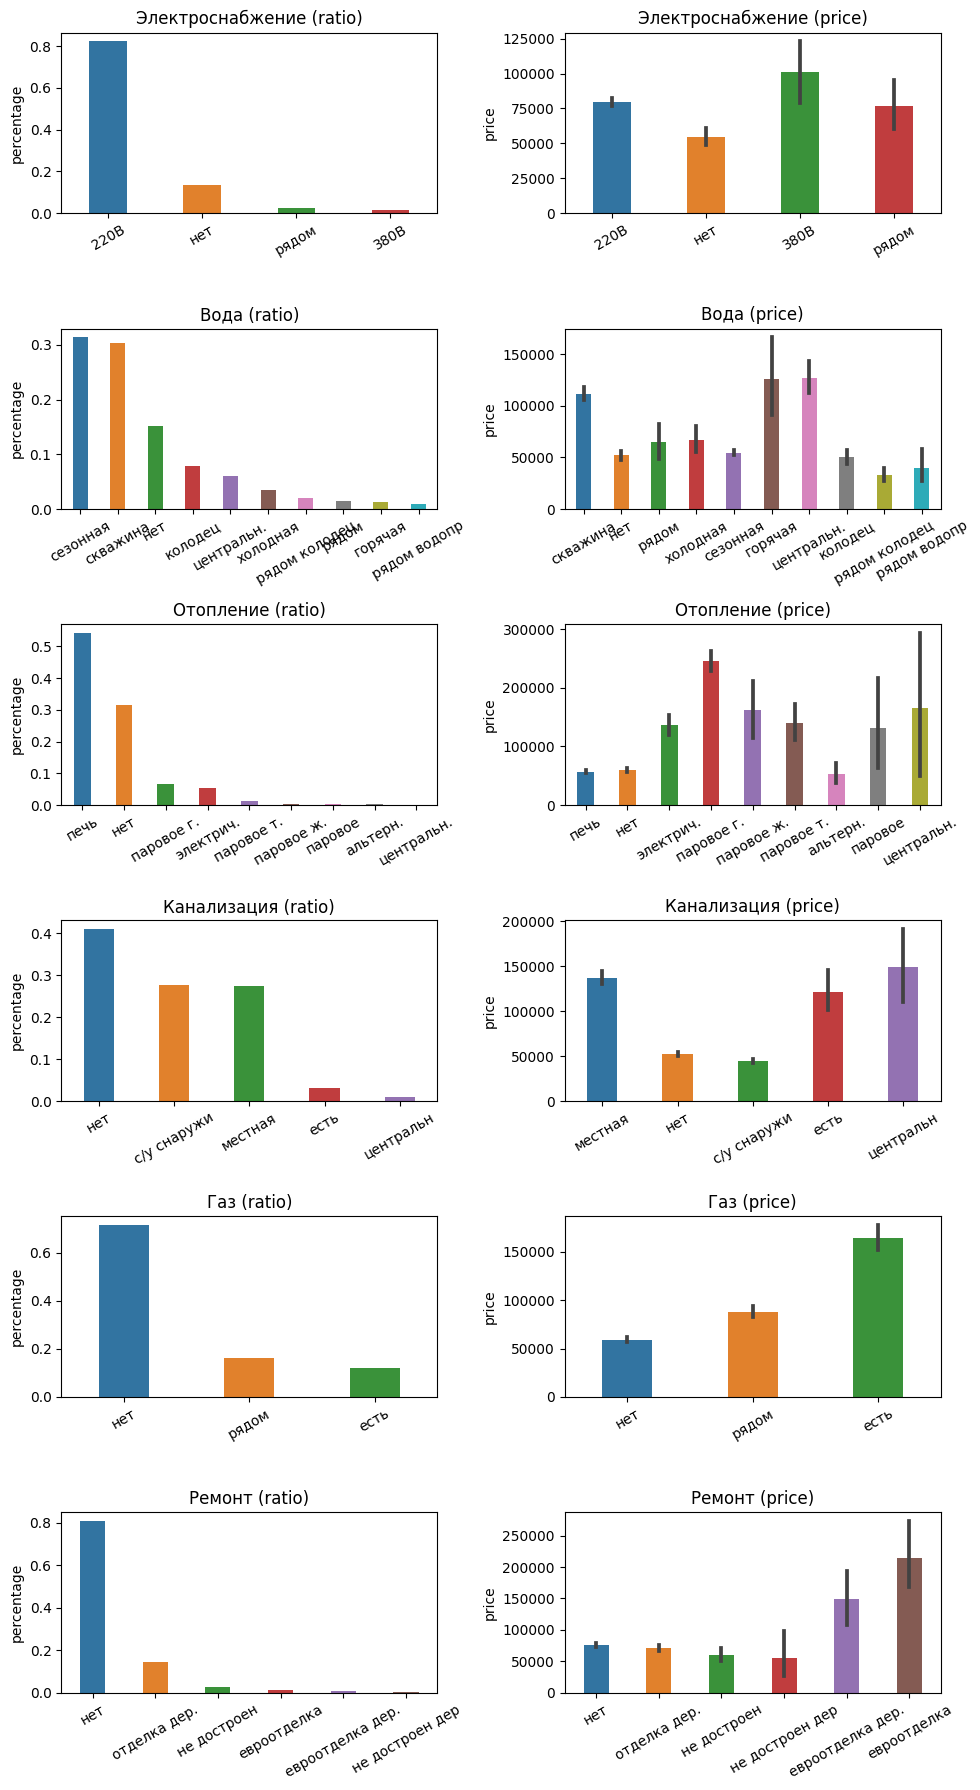

In [265]:
draw_categories(fill_na_net)

In [266]:
class CAT_2_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be fillna with mode-value '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
        X['Материал стен'] = X['Материал стен'].map({
            "['Дерево']":'дерево', 
            "['Кирпичный']":'кирпич', 
            "['Блок', 'газосиликатный']":'блок г/с', 
            "['Блочный']":'блок',
            "['Сборно-щитовой']":'сб-щитовой',
            "['Сруб']":'сруб',
            "['Дерево,', 'обложено', 'кирпичом']":'дер., кирпич',
            "['Белый', 'кирпич']":'кирпич бел.',
            "['Каркасный', 'деревянный']":'каркасн. дер.',
            "['Брус', 'профилированный']":'брус профил.',
            "['Каркасно-засыпной']":'каркасн. засыпн. ',
            "['Брус', 'оцилиндрованный']":'брус оцил.',
            "['Красный', 'кирпич']":'кирпич красн.',
            "['Облицовочный', 'кирпич']":'кирпич облиц.',
            "['Панельный']":'панельн.',
            "['Керамзитбетон']":'керамзитобетон',
            "['Шлакобетон']":'шлакобетон',
            "['Брус', 'клееный']":'брус клеен.',
            "['Монолитно-каркасный']":'каркасн. монол.'
            })

        X['Материал крыши'] = X['Материал крыши'].map({
            "['Шифер']":'шифер', 
            "['Металло-черепица']":'черепица мет.', 
            "['Ондулин']":'ондулин', 
            "['Металл']":'металл',
            "['Евро-шифер']":'е-шифер',
            "['Мягкая', 'черепица']":'черепица мяг.',
            "['Черепица']":'черепица',
            "['Битумная', 'черепица']":'черепица бит.',
            "['Жесть']":'жесть',
            "['Рубероид']":'рубероид',
            "['Гидроизоляция']":'гидроизоляция',
            "['Доски']":'доски',
            "['Природные', 'материалы']":'природн.'
            })

        X['Статус земли'] = X['Статус земли'].map({
            "['Частная']":'частная', 
            "['Пожизненноe', 'наследуемое', 'владение']":'пожизн.', 
            "['Другое']":'частная', 
            "['Аренда']":'аренда',
            })

        X[self.categories] = X[self.categories].fillna(X.mode().iloc[0])
        
        return X
    

cat_2_treat = CAT_2_Transformer(fill_na_mode)
df = cat_2_treat.transform(df)

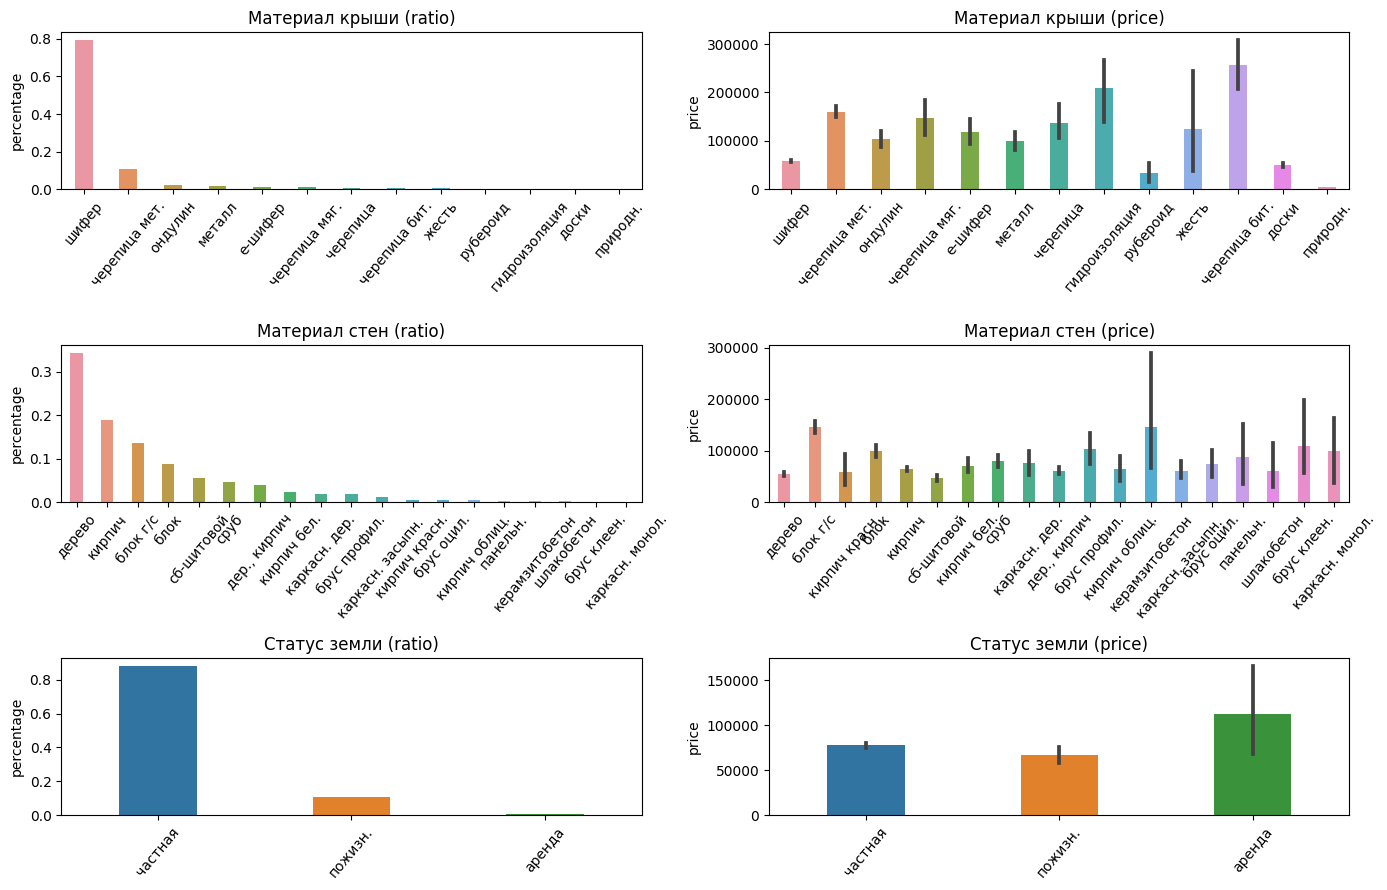

In [267]:
draw_categories(['Материал крыши', 'Материал стен', 'Статус земли'], 14, 50)

In [268]:
class CAT_3_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be managed before fillna '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
        X.loc[X[X['Населенный пункт']=="['г.', 'Минск']"].index,'Район'] = 'г.Минск'
        
        X['house_year'] = df['house_year'].fillna(df.groupby('Населенный пункт')['house_year'].transform(lambda x: x.mode()[0] if len(x.mode())>0 else np.nan))
        X['house_year'] = df['house_year'].fillna(df['house_year'].mode()[0])

        X['Область'] = X['Область'].map({
            "['Гомельская', 'область']":'Гомель', 
            "['Минская', 'область']":'Минск', 
            "['Гродненская', 'область']":'Гродно', 
            "['Брестская', 'область']":'Брест',
            "['Могилевская', 'область']":'Могилев',
            "['Витебская', 'область']":'Витебск'
            })
        
        def tryconvert(value):
            try:
                res = re.findall(r'\'(\w+)\'',value.replace('-',''))
                return res[0]
            except:
                return value
            
        
        X['Сельсовет'] = X['Сельсовет'].apply(lambda x: tryconvert(x))
        X['Сельсовет'] = X['Сельсовет'].fillna(X.groupby('Населенный пункт')['Сельсовет'].transform(lambda x: x.mode()[0] if len(x.mode())>0 else np.nan))
        X['Сельсовет'] = X['Сельсовет'].fillna('unknown')

        X['Район'] = X['Район'].apply(lambda x: tryconvert(x))
        
        #X[self.categories] = X[self.categories].fillna(X.mode().iloc[0])
        
        X.drop(['Направление'], axis=1, inplace=True)
        X = X[X['Район'].notna()]

        return X
    

cat_3_treat = CAT_3_Transformer(fill_na_find)
df = cat_3_treat.transform(df)

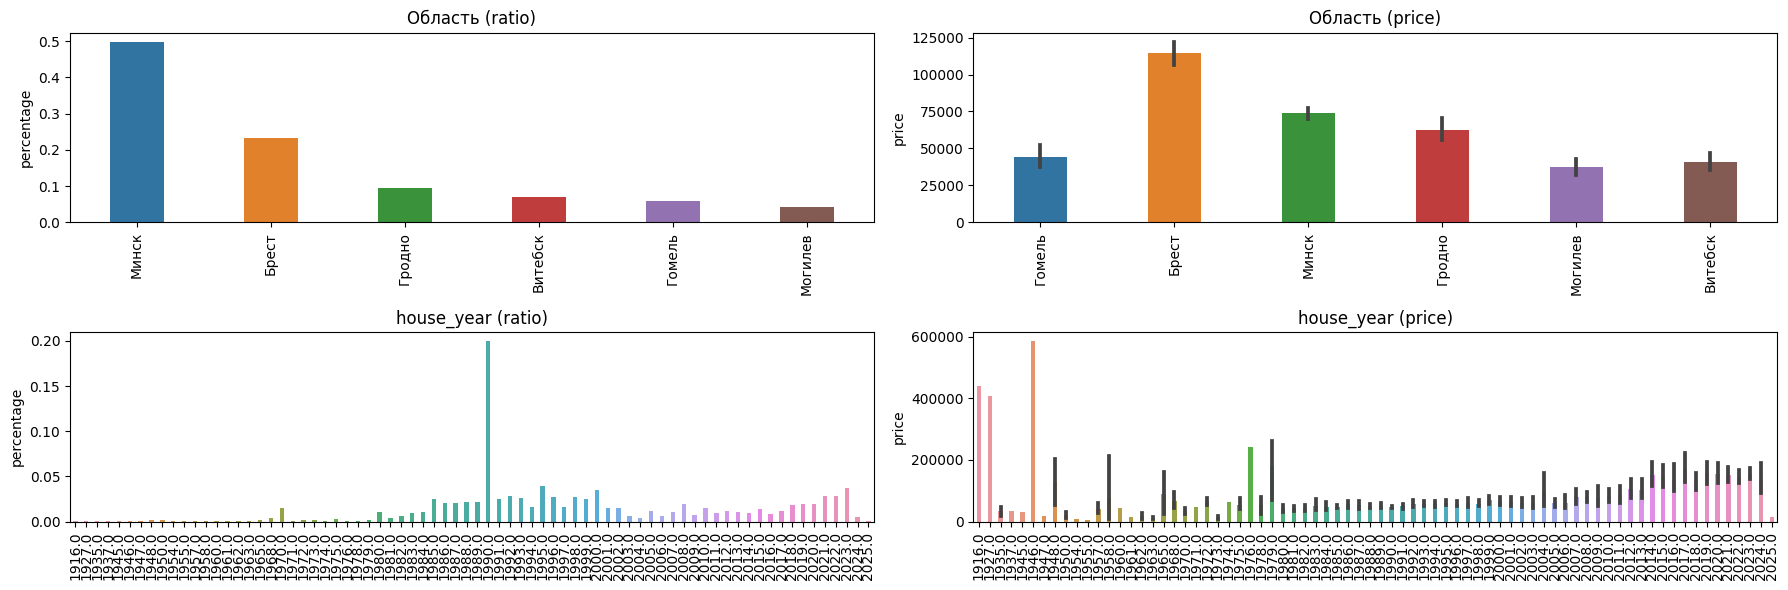

In [269]:
draw_categories(['Область', 'house_year'], 18, 90)

In [270]:
#temp = df['house_year'].isna()
#inds = temp[temp==True].index

#print(f"nan in 'house_year': {df['house_year'].isna().sum()}")
#df['house_year'] = df['house_year'].fillna(df.groupby('Населенный пункт')['house_year'].transform(lambda x: x.mode()[0] if len(x.mode())>0 else np.nan))
#print(f"nan after filling with city mode: {df['house_year'].isna().sum()}")
#df['year'] = df['year'].fillna(df.groupby('Район')['year'].transform(lambda x: x.mode()[0] if len(x.mode())>0 else np.nan))
#print(f"nan after filling with district mode: {df['year'].isna().sum()}")
#df['house_year'] = df['house_year'].fillna(df['house_year'].mode()[0])
#print(f"nan after filling with df mode: {df['house_year'].isna().sum()}")

#temp = df.groupby(['Населенный пункт', 'Район'])['house_year'].apply(lambda x: x.unique())
#temp

In [271]:
#draw_categories(['house_year','house_levels'], 18, 90)

In [272]:
from ipynb.fs.full.parsing_2 import get_district_details

district_dict = dict()


#for i in df['Район'].unique():
#    try:
#        district_dict[i] = get_district_details(i + ' район, Беларусь')
#    except:
#        print(i, "couldn't get data")
#        continue

#df_district = pd.DataFrame(district_dict, index=['district_center_coordinates', 'district_city_coordinates']).T
#df_district.to_csv('data/districts.csv')

In [273]:
df_district = pd.read_csv('data/districts.csv')
df_district = df_district.rename(columns={'Unnamed: 0':'Район'})
df_district.head()

,Район,district_center_coordinates,district_city_coordinates
0,Гомельский,"(52.2527, 31.0048)","(52.263, 31.0)"
1,Брестский,"(52.0655, 23.394)","(52.0529, 23.4024)"
2,Молодечненский,"(54.1849, 26.5106)","(54.1849, 26.5106)"
3,Гродненский,"(53.4, 23.49)","(53.4, 23.49)"
4,Бобруйский,"(53.06, 29.13)","(53.06, 29.13)"


In [274]:
df_merged = pd.merge(df, df_district, how='left', on='Район')
df_merged.head()

,Материал стен,Материал крыши,Отопление,Канализация,Электроснабжение,Вода,Телефон,Область,Район,Населенный пункт,...,house_year,house_readiness,house_coordinates,price,liv_house_area,kitchen_area,house_width,house_length,district_center_coordinates,district_city_coordinates
0,дерево,шифер,печь,местная,220В,скважина,1,Гомель,г.Минск,"['с/т', 'Родны', 'кут']",...,2000.0,100.0,"(52.330913, 30.814533)",9114.0,12.0,10.0,NaN,NaN,"(53.55, 27.33)","(53.55, 27.33)"
1,блок г/с,шифер,печь,местная,220В,скважина,0,Брест,г.Минск,"['Знаменский', 'с/с']",...,1991.0,100.0,"(52.010669, 23.717579)",83003.0,43.1,7.2,NaN,NaN,"(53.55, 27.33)","(53.55, 27.33)"
2,кирпич красн.,шифер,печь,нет,220В,нет,0,Минск,г.Минск,"['с/т', 'АЛМАЗ-2002']",...,1990.0,100.0,"(54.389141, 26.682371)",41990.0,60.0,10.0,NaN,NaN,"(53.55, 27.33)","(53.55, 27.33)"
3,дерево,шифер,нет,нет,220В,нет,0,Брест,г.Минск,"['с/т', 'Южное-2']",...,1994.0,100.0,"(52.071528, 23.786624)",56963.0,40.0,10.0,NaN,NaN,"(53.55, 27.33)","(53.55, 27.33)"
4,блок,шифер,нет,нет,нет,нет,0,Гродно,г.Минск,"['с/т', 'Колос-Жиличи']",...,1995.0,100.0,"(53.620568, 23.984891)",35805.0,40.0,10.0,NaN,NaN,"(53.55, 27.33)","(53.55, 27.33)"


In [275]:
#df['district_center_coordinates'] = df['Район'].apply(lambda x: district_dict[x] if x in district_dict else district_dict['Минский'])
#dfc['city_coordinates'] = dfc.apply(lambda x: (x.latitude_x, x.longitude_x), axis=1)
#dfc['district_center_coordinates'] = dfc.apply(lambda x: (float(x.latitude), float(x.longitude)), axis=1)
#dfc.loc[dfc['Населенный пункт']=="['г.', 'Минск']",'district_center_coordinates'] = str(regions_dict['Минск'])

#dfc.drop(['latitude', 'longitude',], axis=1, inplace=True)
df_merged.to_csv('data/country_houses_treated.csv')

In [276]:
dfc = pd.read_csv('data/country_houses_treated.csv', index_col=0)
dfc.tail(3)

,Материал стен,Материал крыши,Отопление,Канализация,Электроснабжение,Вода,Телефон,Область,Район,Населенный пункт,...,house_year,house_readiness,house_coordinates,price,liv_house_area,kitchen_area,house_width,house_length,district_center_coordinates,district_city_coordinates
2939,дерево,шифер,нет,нет,нет,колодец,0,Гродно,г.Минск,"['с/т', 'Демидково']",...,2010.0,100.0,"(53.522132, 23.790479)",10416.0,40.0,10.0,NaN,NaN,"(53.55, 27.33)","(53.55, 27.33)"
2940,каркасн. дер.,е-шифер,печь,есть,220В,колодец,0,Минск,г.Минск,"['с/т', 'Западная', 'Березина']",...,2019.0,100.0,"(54.117371, 26.437489)",21158.0,40.0,10.0,NaN,NaN,"(53.55, 27.33)","(53.55, 27.33)"
2941,блок г/с,черепица мет.,нет,местная,рядом,скважина,0,Брест,г.Минск,"['с/т', 'Зеленый', 'бор']",...,2022.0,100.0,"(52.042633, 23.760319)",170888.0,40.0,10.0,NaN,NaN,"(53.55, 27.33)","(53.55, 27.33)"


### New features

In [277]:
def get_location(name):
    try:
        g = geocoder.bing(name, key='AgY4Qy8qL2I1oMf6xu6SSpqncKEFzpjZIKzs3Y_lhKvdA4cRPMUpBEIDmgXxm5_e')
        results = g.json
        #print(name, results['lat'], results['lng'])
        return (results['lat'], results['lng'])
    except:
        print('exception', name)
        return name


regions_dict = dict()
regions = df['Область'].unique()
for item in regions:
    if type(item) is str:
        regions_dict[item] = get_location(item + ', беларусь')
    else:
        continue


dfc['regional_center_coordinates'] = dfc['Область'].apply(lambda x: str(regions_dict[x]) )

In [278]:
def get_distance(d1,d2):
    coord1 = d1.replace(',',' ').lstrip('(').rstrip(')').split()
    coord2 = d2.replace(',',' ').lstrip('(').rstrip(')').split()
    return geopy.distance.geodesic((float(coord1[0]),float(coord1[1])), (float(coord2[0]),float(coord2[1]))).km

dfc['distance_house_district'] = dfc.apply(lambda x: get_distance(x['house_coordinates'], x['district_center_coordinates']), axis=1)
dfc['distance_house_region'] = dfc.apply(lambda x: get_distance(x['house_coordinates'], x['regional_center_coordinates']), axis=1)
dfc['distance_house_minsk'] = dfc.apply(lambda x: get_distance(x['house_coordinates'], str(regions_dict['Минск'])), axis=1)

dfc.loc[400:410, ['Населенный пункт','Район','distance_house_district',  'distance_house_region','distance_house_minsk']]



,Населенный пункт,Район,distance_house_district,distance_house_region,distance_house_minsk
400,"['с/т', 'Ольха-91']",г.Минск,312.720520,27.639759,347.787463
401,"['с/т', 'Сутоки']",г.Минск,87.474554,48.500760,48.500760
402,"['с/т', 'Елочка']",г.Минск,45.728538,32.543176,32.543176
403,"['д.', 'Новая', 'Милеевка']",г.Минск,204.250382,20.587463,188.975308
404,"['с/т', 'Асвета']",г.Минск,61.327720,71.864257,71.864257
405,"['Мухавецкий', 'с/с']",г.Минск,290.068754,9.874946,324.650963
406,"['Воложинский', 'с/с']",г.Минск,52.403501,27.225478,27.225478
407,"['д.', 'Веречье']",г.Минск,299.111839,45.443409,260.435535
408,"['д.', 'Николаевка', '3']",г.Минск,207.157570,4.595543,187.536243
409,"['Мухавецкий', 'с/с']",г.Минск,290.068754,9.874946,324.650963


In [279]:
dfc = dfc.drop(['house_length', 'house_width'], axis=1)
#dfc = dfc.drop(['regional_center_coordinates', 'district_center_coordinates', 'house_coordinates', 'Населенный пункт'], axis=1)


In [280]:
#f,a = plt.subplots(figsize=(10,10))
#sns.heatmap(dfc.corr(numeric_only=True))

In [281]:
ohe_list = ['Материал стен', 'Материал крыши', 'Отопление', 'Канализация', 'Электроснабжение', 'Вода','Область', 'Район', 'Газ', 'Статус земли', 'Ремонт']
dfc_dummies = pd.get_dummies(dfc, columns=ohe_list)

#encoder = ce.OneHotEncoder(cols=ohe_list, use_cat_names=True)
#add = encoder.fit_transform(dfc.loc[:,ohe_list])
#dff = pd.concat([dfc,add], axis=1)
dfc_dummies

,Телефон,Населенный пункт,Сельсовет,Баня,Гараж,Сад,Хозпостройки,Рядом лес,Водоем,Ландшафтный дизайн,...,Газ_рядом,Статус земли_аренда,Статус земли_пожизн.,Статус земли_частная,Ремонт_евроотделка,Ремонт_евроотделка дер.,Ремонт_не достроен,Ремонт_не достроен дер,Ремонт_нет,Ремонт_отделка дер.
0,1,"['с/т', 'Родны', 'кут']",Бобовичский,0,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False
1,0,"['Знаменский', 'с/с']",Знаменский,1,1,1,1,0,0,0,...,True,False,False,True,False,False,False,False,True,False
2,0,"['с/т', 'АЛМАЗ-2002']",Лебедевский,0,1,0,0,1,1,0,...,False,False,False,True,False,False,False,False,True,False
3,0,"['с/т', 'Южное-2']",Знаменский,0,0,0,0,0,0,0,...,True,False,False,True,False,False,False,False,True,False
4,0,"['с/т', 'Колос-Жиличи']",Коптёвский,0,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,0,"['аг.', 'Юзуфово']",Юзуфовский,0,1,1,1,1,1,1,...,False,False,False,True,False,False,False,False,True,False
2938,0,"['с/т', 'Вымпел', 'УВД']",Мухавецкий,0,0,0,0,0,0,0,...,True,False,False,True,False,False,False,False,True,False
2939,0,"['с/т', 'Демидково']",Квасовский,0,0,0,1,0,0,0,...,False,False,False,True,False,False,False,False,True,False
2940,0,"['с/т', 'Западная', 'Березина']",Саковщинский,1,0,1,1,1,1,1,...,False,False,False,True,False,False,False,False,True,False


In [282]:
#dff = dff.drop(ohe_list, axis=1)
dff = dfc_dummies.drop(['house_coordinates','regional_center_coordinates','district_center_coordinates', 'district_city_coordinates', 'Населенный пункт', 'Сельсовет'], axis=1)
dff.head(3)

,Телефон,Баня,Гараж,Сад,Хозпостройки,Рядом лес,Водоем,Ландшафтный дизайн,Теплица,Мебель,...,Газ_рядом,Статус земли_аренда,Статус земли_пожизн.,Статус земли_частная,Ремонт_евроотделка,Ремонт_евроотделка дер.,Ремонт_не достроен,Ремонт_не достроен дер,Ремонт_нет,Ремонт_отделка дер.
0,1,0,0,0,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False
1,0,1,1,1,1,0,0,0,0,0,...,True,False,False,True,False,False,False,False,True,False
2,0,0,1,0,0,1,1,0,0,0,...,False,False,False,True,False,False,False,False,True,False


In [283]:
#Объявляем функцию, реализующую фильтрацию выбросов по методу z-отклонений
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 2.5 * sigma
    upper_bound = mu + 2.5 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned
#Производим очистку 
outliers, dff_cleaned = outliers_z_score(dff, 'price', log_scale=True)

print('Shape before cleaning outliers: {}'.format(dff.shape))
print('Shape after cleaning outliers: {}'.format(dff_cleaned.shape))

Shape before cleaning outliers: (2942, 107)
Shape after cleaning outliers: (2904, 107)


### Models

In [284]:
X = dff_cleaned.drop('price', axis=1)
y = dff_cleaned['price']

scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=40)

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (2323, 106)
Test shape: (581, 106)


In [285]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

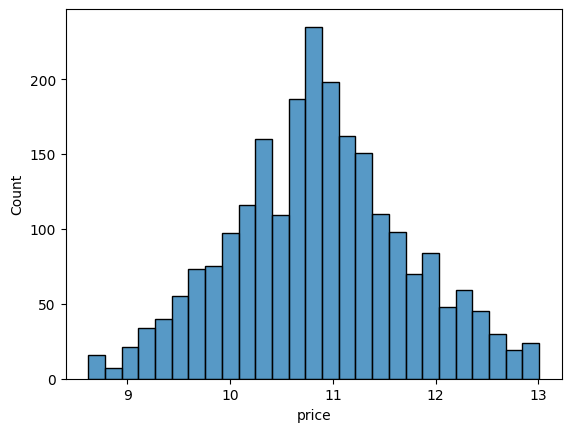

In [286]:
sns.histplot(np.log(y_train));

In [287]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.682
Train MAE: 27019.916
Train MAPE: 57.790


Test R^2: 0.617
Test MAE: 27827.928
Test MAPE: 58.946


In [288]:
sgdr = linear_model.SGDRegressor(random_state=40)
sgdr.fit(X_train, y_train)

y_train_pred = sgdr.predict(X_train)
y_test_pred = sgdr.predict(X_test)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.651
Train MAE: 27927.092
Train MAPE: 55.853


Test R^2: 0.615
Test MAE: 28204.480
Test MAPE: 56.183


In [289]:
y_train_log = np.log(y_train)

sgdr = linear_model.SGDRegressor(random_state=40)
sgdr.fit(X_train, y_train_log)

y_train_pred = np.exp(sgdr.predict(X_train))
y_test_pred = np.exp(sgdr.predict(X_test))

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.556
Train MAE: 29050.847
Train MAPE: 46.972


Test R^2: 0.499
Test MAE: 30347.306
Test MAPE: 46.005


In [297]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

print('Train shape: {}'.format(X_train_poly.shape))
print('Test shape: {}'.format(X_test_poly.shape))


lr_poly = linear_model.Ridge(alpha=20)

lr_poly.fit(X_train_poly, y_train_log)

y_train_pred = np.exp(lr_poly.predict(X_train_poly))
y_test_pred = np.exp(lr_poly.predict(X_test_poly))
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train shape: (2323, 5777)
Test shape: (581, 5777)
Train R^2: 0.794
Train MAE: 19360.796
Train MAPE: 30.945


Test R^2: 0.620
Test MAE: 26446.377
Test MAPE: 45.488


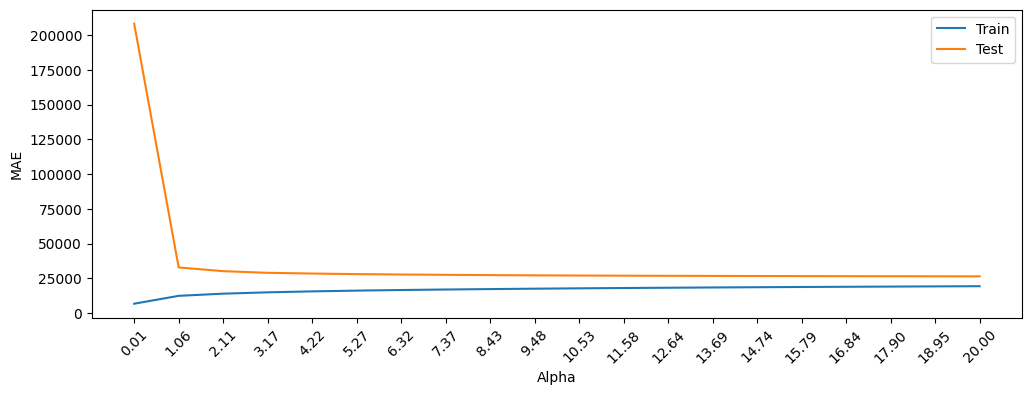

In [294]:
alpha_list = np.linspace(0.01, 20, 20)
#Создаем пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаем объект класса линейная регрессия с L2-регуляризацией
    ridge_lr_poly = linear_model.Ridge(alpha=alpha, max_iter=10000)
    #Обучаем модель предсказывать логарифм целевого признака
    ridge_lr_poly.fit(X_train_poly, y_train_log)
    #Делаем предсказание для каждой из выборок
    #Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
    y_train_predict_poly = np.exp(ridge_lr_poly.predict(X_train_poly))
    y_test_predict_poly = np.exp(ridge_lr_poly.predict(X_test_poly))
    #Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores.append(metrics.mean_absolute_error(y_train, y_train_predict_poly))
    test_scores.append(metrics.mean_absolute_error(y_test, y_test_predict_poly))

#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('MAE') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды    #Делаем предсказание для каждой из выборок


In [304]:
# Создаем модель дерева решений с максимальной глубиной 10 
dtr = DecisionTreeRegressor(max_depth=10, random_state=42)
# Обучаем модель
dtr.fit(X_train, y_train_log)

y_train_pred = np.exp(dtr.predict(X_train))
y_test_pred = np.exp(dtr.predict(X_test))
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.914
Train MAE: 12025.649
Train MAPE: 23.622


Test R^2: 0.558
Test MAE: 29035.073
Test MAPE: 50.345


In [ ]:
rfr = RandomForestRegressor(max_depth=1000, n_estimators=10, random_state=42)
# Обучаем модель
rfr.fit(X_train, y_train)

In [ ]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', RidgeCV()),
    ('linr',  linear_model.LinearRegression())
    #('dt',  DecisionTreeRegressor(random_state=42))
]

# Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators,
    #final_estimator=RandomForestRegressor(n_estimators=10, random_state=42)
    final_estimator=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
)
# Обучаем модель
reg.fit(X_train, y_train)

In [305]:
from sklearn.ensemble import GradientBoostingRegressor

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    max_depth=3, #максимальная глубина дерева
    n_estimators=100, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
)

# Обучаем модель
gb.fit(X_train, y_train_log)

y_train_pred = np.exp(gb.predict(X_train))
y_test_pred = np.exp(gb.predict(X_test))
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.785
Train MAE: 20342.275
Train MAPE: 32.725


Test R^2: 0.706
Test MAE: 23645.739
Test MAPE: 38.948
